In [53]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
from pathlib import Path
import numpy as np 
import os
import PIL
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, ReLU, Rescaling

Let us first count the number of images in each folder relating to a single emotion.

In [23]:
data_path = "../Data"
main_path = Path(data_path)
emotions = ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
for emotion in emotions: 
    path = Path(data_path)/emotion
    num_images = len(list(path.glob("*.png")))
    print(f"{emotion} folder has {num_images} images")

Angry folder has 9906 images
Fear folder has 9714 images
Happy folder has 17983 images
Sad folder has 12157 images
Suprise folder has 8004 images


In [33]:
image = PIL.Image.open(main_path / "Happy" / "14.png")
image.size


(48, 48)

Now, we shall load these directories into a training and validation dataset directly by using the tf.keras.utils.image_dataset_from_directory() function which can automatically infer labels which helps us save time. 

In [38]:
img_height = 256
img_width = 256
batch_size = 32

In [39]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred')


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred')

Found 59099 files belonging to 5 classes.
Using 47280 files for training.
Found 59099 files belonging to 5 classes.
Using 11819 files for validation.


In [40]:
class_names = train_ds.class_names

2025-11-07 02:03:10.057225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


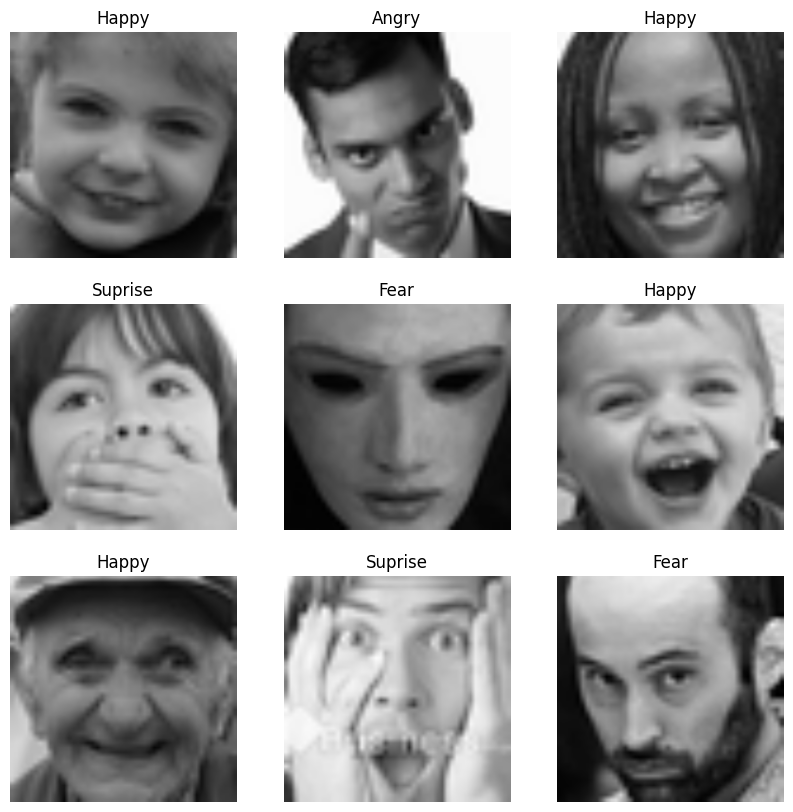

In [41]:
plt.figure(figsize = (10,10))
for image, label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3,i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [61]:
for batch, labels in train_ds.take(1):
    print(batch.shape)

(32, 256, 256, 3)


2025-11-07 02:19:24.506493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
AUTOTUNE = tf.data.AUTOTUNE

In [49]:
def prepare_dataset(data):
    return data.cache().prefetch(buffer_size = AUTOTUNE)

train_ds_final = train_ds.apply(prepare_dataset)
val_ds_final = val_ds.apply(prepare_dataset)

    

In [62]:
num_classes = 5
model = Sequential([
    Rescaling(1./255, input_shape = (256,256,3)),
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size= (2,2)),
    Conv2D(filters = 128, kernel_size = (5,5), strides = (1,1), padding = 'same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size= (2,2)),
    Conv2D(filters = 128, kernel_size = (5,5), strides = (1,1), padding = 'same'), 
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D(pool_size= (2,2)),
    Conv2D(filters = 64, kernel_size = (5,5), strides = (1,1), padding = 'same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D(pool_size= (2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(num_classes, activation = 'softmax') 
    ])


/opt/anaconda3/envs/image-forgery-env/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,871,813 (7.14 MB)

 Trainable params: 1,871,045 (7.14 MB)

 Non-trainable params: 768 (3.00 KB)

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights= True) 

In [66]:
model.fit(train_ds,validation_data=val_ds,epochs=10, callbacks = [early_stopping])

Epoch 1/10
 566/1478 ━━━━━━━━━━━━━━━━━━━━ 1:42:19 7s/step - accuracy: 0.3298 - loss: 2.0441

KeyboardInterrupt: 